# Notes

**Important**

This notebook was created on *April 23, 2024, at 19:08*  with the intention of providing detailed explanations and interpretations of the processes involved. While Python scripts are powerful, they can sometimes be complex and require a significant investment in terms of analysis and understanding. This document aims to simplify this task by breaking down and explaining each code segment in detail.

In this notebook, we will undertake to revisit and detail the implementations of the MNIST dataset, a dataset widely used in the machine learning community, initially popularized by Yann LeCun. The goal is to implement two types of neural architectures: a Multi-Layer Perceptron (MLP) and a Convolutional Neural Network (CNN). We will then compare their performances through various metrics.

Additionally, special attention will be given to visualizing backpropagation to identify the global optimum. This approach aims to illustrate not only how modifications to the weights affect model accuracy during training but also to demonstrate optimization dynamics in action.

This work is essential for those looking to deepen their understanding of deep learning fundamentals as well as for those wishing to refine their ability to optimize machine learning algorithms.

## Setup

In [29]:
import numpy as np
import matplotlib.pyplot as plt

## PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [30]:
# Load data
train_data = torchvision.datasets.MNIST(root='data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())

test_data = torchvision.datasets.MNIST(root='data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor()
)

print('Data are ready!')

Data are ready!


We have downloaded the data, now to extract the images and labels we will type the following command:

```bash
X = train_data.data
y = train_data.targets
```

In [31]:
# Examples
# Images are in uint8
print(f'The label ==> {train_data.targets[0]}')
train_data.data[0]

The label ==> 5


tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

## Preparation

We are going to prepare the images here. The images are already in an appropriate format and require no special preparation other than normalization. As you may notice, the pixel values range from 0 to 255. This range can increase the computational load and introduce significant variance. Therefore, it is crucial to normalize the data. Using a MinMaxScaler normalization could be beneficial to scale our data from 0 to 1.

The MinMax normalization formula is given by: $MinMax = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$.

Next, we will load these normalized data into a DataLoader, which will compact our data and organize it into batches. This will enable us to use the GPU for computations, making the process more efficient.

In [32]:
# Store the data
# Print dimension of the data
print(f'train_data ==> {train_data.data.shape}')
print(f'test_data ==> {test_data.data.shape}')

train_data ==> torch.Size([60000, 28, 28])
test_data ==> torch.Size([10000, 28, 28])


In [33]:
def plot_images_grid_from_dataset(dataset, num_images=25, title=None):
    """
    Plots a grid of images with labels directly from the dataset.

    Args:
    dataset (torch.utils.data.Dataset): Dataset from which to load the data.
    num_images (int): Number of images to display in the grid.
    title (str): Title of the plot.
    """
    if len(dataset) < num_images:
        raise ValueError("The dataset contains fewer images than the number requested for display.")
    
    # Manually fetch a batch of images and labels
    images = []
    labels = []
    for i in range(num_images):
        image, label = dataset[i]
        images.append(image)
        labels.append(label)
    
    # Convert lists to tensor
    images = torch.stack(images)
    labels = torch.tensor(labels)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(images, nrow=int(num_images ** 0.5), normalize=True, scale_each=True)

    # Show images
    plt.figure(figsize=(10, 10))
    plt.imshow(img_grid.permute(1, 2, 0), cmap='gray', vmin=0, vmax=1)  # Rearrange the order of channels
    plt.axis('off')
    
    # Adding the title
    if title:
        plt.title(title)

    # Show labels in the title or a legend (optional)
    labels_str = ', '.join(map(str, labels.tolist()))
    plt.xlabel(f"Labels: {labels_str}")

    plt.show()

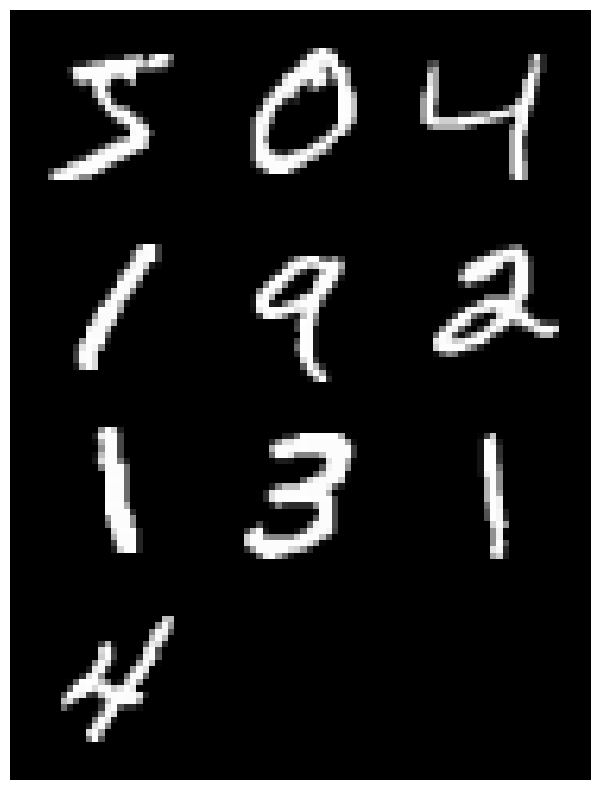

In [34]:
plot_images_grid_from_dataset(train_data, num_images=10)

These results indicate that our dataset contains 60,000 images, each with a height and width of 28 pixels. The structure of these data in a three-dimensional tensor (observations, height, width) also reveals that the images are in black and white, using a single channel. For color images, the tensor structure would include a fourth dimension corresponding to the color channels.

Let's move on to normalization:
The pixel values range from 0 to 255. Since the minimum value 
𝑋_min
X_min is zero, we can simplify the normalization by merely dividing each pixel by 255. This operation scales the pixel values to the range [0, 1], which is often required to optimize the performance of machine learning algorithms.

In [35]:
# Normalization
train_data.data = train_data.data / 255.0
test_data.data = test_data.data / 255.0

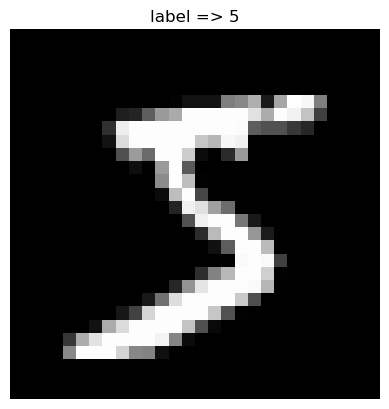

In [36]:
plt.title(f'label => {train_data.targets[0].numpy()}')
plt.axis('off')
plt.imshow(train_data.data[0], cmap='gray')

In [37]:
# Injection
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

## Modeling

In [38]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.input = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.hl_1 = nn.Linear(hidden_size, hidden_size) 
        self.out = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.input(x))
        x = self.relu(self.hl_1(x))
        x = self.out(x) 
        return F.softmax(x, dim=1) 